In [2]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Child class of the nntools NeuralNetwork class
class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [5]:
# Child class of the NNRegressor class
class VGGTransfer(NNRegressor):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGGTransfer, self).__init__()
        vgg = tv.models.vgg16(pretrained=True) # get pretrained VGG16
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        self.net = nn.ModuleList()
        self.net = vgg.features # get just the CNN layers, no fully connected layers
    # do a forward pass through the network.  Return a dictionary wit the desired layer activations
    def forward(self, x):
        rep = {}
        rep['r12'] = self.net[:4](x)
        rep['r22'] = self.net[:9](x)
        rep['r33'] = self.net[:16](x)
        rep['r43'] = self.net[:23](x)

        
        
        return rep #

In [6]:
# Class to implement conv layer with stride 1/2 for use in the ImageTransorm class
class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [7]:
# Image Transorm matrix as described by Johnson et al
class ImageTransform(torch.nn.Module):
    def __init__(self):
        super(ImageTransform, self).__init__()
    
        self.pad = torch.nn.ReflectionPad2d((40,40,40,40))
        self.conv1 = torch.nn.Conv2d(3,32,9,padding=4)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32,64,3,stride=2,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64,128,3,stride=2,padding=1)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.res1 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res2 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res3 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res4 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res5 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.conv4 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.conv5 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.bn5 = torch.nn.BatchNorm2d(32)
        self.conv6 = torch.nn.Conv2d(32,3,9,padding=4)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
    
        h = self.pad(x)
        
        h = F.relu(self.bn1(self.conv1(h)))
        
        h = F.relu(self.bn2(self.conv2(h)))
        
        h = F.relu(self.bn3(self.conv3(h)))
        
        h = F.relu(h[:,:,2:82,2:82] + self.res1(h)) 
        
        h = F.relu(h[:,:,2:78,2:78] + self.res2(h))
        
        h = F.relu(h[:,:,2:74,2:74] + self.res3(h))
        
        h = F.relu(h[:,:,2:70,2:70] + self.res4(h))
        
        h = F.relu(h[:,:,2:66,2:66] + self.res4(h))
        
        h = F.relu(self.bn4(self.conv4(h)))
        
        h = F.relu(self.bn5(self.conv5(h)))
        
        h = self.conv6(h)
        
        y = (self.tanh(h) + 1) / 2
        return y
ImageTransformNet = ImageTransform()
for param in ImageTransformNet.parameters():
    param.requires_grad = True

In [8]:
# DnCNN class from Assignment 4. Used in place of ImageTransform for experimentation
class DnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        
        for k in range(D):
            h = F.relu(self.bn[k](self.conv[k + 1](h)))
        
        y = self.conv[D+1](h) + x
        return y

In [9]:
# UDnCNN class from Assignment 4. Used in place of ImageTransform for experimentation
class UDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
        
    def forward(self, x):
        D = self.D
        h1 = F.relu(self.conv[0](x))
        h = h1
        
        features = []
        features.append(h1)
        indeces = []
        
        # Contracting
        for k in range(int(D/2 - 1)):
            r = F.relu(self.bn[k](self.conv[k + 1](h)))
            h, ind = F.max_pool2d(r, kernel_size=2, return_indices=True)
            features.append(h)
            indeces.append(ind)
            
        inner1 = F.relu(self.bn[int(D/2 - 1)](self.conv[int(D/2)](features[int(D/2 - 1)])))
        inner2 = F.relu(self.bn[int(D/2)](self.conv[int(D/2)+1](inner1)))
        
        h = inner2
        
        # Expanding
        for k in range(int(D/2 + 1), D):
            p = F.max_unpool2d((h + features[D-k])/np.sqrt(2), indices=indeces[D-k-1], 
                               kernel_size=2, output_size=features[D-k-1].shape)
            h = F.relu(self.bn[k](self.conv[k + 1](p)))
        
        
        y = self.conv[D + 1]((h + h1) / np.sqrt(2)) + x
                                  
        return y

In [10]:
# DUDnCNN class from Assignment 4. Used in place of ImageTransform for experimentation
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        self.conv.append(nn.Conv2d(C, C, 3, padding=1))  
        
        for k in range(1, int(D/2)):
            self.conv.append(nn.Conv2d(C, C, 3, padding=2**k, dilation=2**k))  
        
        for k in range(int(D/2) + 1, D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=2**(D-k), dilation=2**(D-k)))
            
        self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        
        features = []
        features.append(h)
        
        outer1 = F.relu(self.bn[0](self.conv[1](h)))
        
        features.append(outer1)
        
        for k in range(int(D/2)):
            torch.backends.cudnn.benchmark=True
            h = F.relu(self.bn[k+1](self.conv[k + 2](h)))
            torch.backends.cudnn.benchmark=False
            features.append(h)
        
        for k in range(int(D/2) + 1, D - 1):
            torch.backends.cudnn.benchmark=True
            h = F.relu(self.bn[k](self.conv[k + 1]((h + features[D-k])/np.sqrt(2))))
            torch.backends.cudnn.benchmark=False
            
        outer2 = F.relu(self.bn[D-1](self.conv[D]((h + outer1) / np.sqrt(2))))
        
        y = self.conv[D+1]((outer2 + features[0]) / np.sqrt(2)) + x
        return y

In [11]:
# Paths to dataset
datasetTrainDir = "/datasets/COCO-2015/train2014"
datasetTestDir = "/datasets/COCO-2015/val2014"

In [12]:
# child of Dataset to pull images from the COCO dataset
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode = 'train', image_size=(256, 256)):
        super(COCODataset, self).__init__()
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir)
        self.files = os.listdir(self.images_dir)
        self.mode = mode
    def __len__(self):
        return len(self.files)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
            ])
        clean = transform(clean)
        return clean

In [13]:
# myimshow provided in assignments
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

train_set = COCODataset(datasetTrainDir)
test_set = COCODataset(datasetTestDir)

x = train_set.__getitem__(11).shape
print(x)

torch.Size([3, 256, 256])


In [14]:
# Prepare a "Style" image and a photo that is not in the dataset to test.
transform = tv.transforms.Compose([
            tv.transforms.Resize((256,256)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
            ])
photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:] # add a singleton dimension for the batch size

art_path = 'picasso.jpg'
art = Image.open(art_path)
styleimage = transform(art)
styleimage = styleimage[None,:,:,:]
styleimage = styleimage.to(device)

p = p.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 51.5MB/s] 


In [15]:
# Compute the gram matrices described in Johnson
def Gram(featresp):
    return torch.bmm(featresp,featresp.transpose(1, 2))  

In [16]:
# To calculate the variation loss
def totalvariation(image):
    
    loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
        torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

In [17]:
# get 100 images
image_list = []
for i in range(100):
    image_list.append(train_set.__getitem__(i))

In [18]:
# Function to train the transform network.  Saves model to model_path.  Returns the trained model and total loss history
def styletransfer(train_set, transformNet, model_path, device, styleimage, \
                  content_weight=1, style_weight=1, var_weight=1): 
    # size of training set
    N = train_set.__len__()
    # size of minibatch
    B = 4
    # number of minibatches
    NB = int((N+B-1)/B) 

    optimizer = torch.optim.Adam(transformNet.parameters(), lr=.001)

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7,6))

    loss_history = []
    
    vgg = VGGTransfer().to(device)
    styleoutput = vgg(styleimage)
    # style losses
    styleout12 = styleoutput['r12'].view(1,64,-1) #relu12
    styleout22 = styleoutput['r22'].view(1,128,-1) #relu22
    styleout33 = styleoutput['r33'].view(1,256,-1) #relu33
    styleout43 = styleoutput['r43'].view(1,512,-1) #relu43

    #get style gram matrices
    gram1o = Gram(styleout12)/(styleout12.numel())
    gram2o = Gram(styleout22)/(styleout22.numel())
    gram3o = Gram(styleout33)/(styleout33.numel())
    gram4o = Gram(styleout43)/(styleout43.numel())
    
    for epochs in range(2):

        shuffled_indices = np.random.permutation(range(N))

        for i in range(NB):
            optimizer.zero_grad()
            
            # Prepare minibatch size 4
            minibatch_indices = shuffled_indices[B*i:min(B*(i+1), N)]
            
            p1 = train_set.__getitem__(minibatch_indices[0])
            p2 = train_set.__getitem__(minibatch_indices[1])
            p3 = train_set.__getitem__(minibatch_indices[2])
            p4 = train_set.__getitem__(minibatch_indices[3])
            
            contentimage = torch.stack((p1,p2,p3,p4))
            contentimage = contentimage.to(device)

            yhat = transformNet(contentimage).to(device) 
            yhatvarloss = totalvariation(yhat)
            
            # yhat through vgg
            output = vgg(yhat)
            yhatout12 = output['r12'].view(B,64,-1)  #relu12
            yhatout22 = output['r22'].view(B,128,-1) #relu22
            yhatout33 = output['r33'].view(B,256,-1) #relu33
            yhatout43 = output['r43'].view(B,512,-1) #relu43

            # content losses
            contentoutput = vgg(contentimage)
            contentout33 = contentoutput['r33'].view(B,256,-1) #relu33
            #2matrix norm?
            contentloss = ((contentout33 - yhatout33)**2).sum() / (yhatout33.numel())

            #get yhat gram matrices
            gram1 = Gram(yhatout12)/(yhatout12.numel()/B)
            gram2 = Gram(yhatout22)/(yhatout22.numel()/B)
            gram3 = Gram(yhatout33)/(yhatout33.numel()/B)
            gram4 = Gram(yhatout43)/(yhatout43.numel()/B)


            #get frobenius square norm
            l1 = torch.norm(gram1-gram1o, dim=(1,2))**2 / B
            l2 = torch.norm(gram2-gram2o, dim=(1,2))**2 / B
            l3 = torch.norm(gram3-gram3o, dim=(1,2))**2 / B
            l4 = torch.norm(gram4-gram4o, dim=(1,2))**2 / B

            #total style loss
            styleloss = (l1.sum() + l2.sum() + l3.sum() + l4.sum()) / 4

            #get total loss
            loss = (content_weight * contentloss) + (style_weight * styleloss) + (var_weight * yhatvarloss)

            #backprop
            loss.backward()

            #parameter search
            optimizer.step()

            #display during optimization
            if i % 10 == 0:

                torch.save(transformNet, model_path)

                lo = loss.detach().cpu()
                loss_history.append(lo)

                axes[1].clear()
                axes[1].plot(loss_history)

                print('loss',loss)
                print('contentloss', content_weight*contentloss)
                print('styleloss', style_weight*styleloss)
                print('varloss', var_weight * yhatvarloss)
                
                axes[0].clear()
                image = image_list[1]
                image = image[None,:,:,:]
                image = image.to(device)
                stylized_image = transformNet(image)
                xx = stylized_image.detach().cpu()
                xx = xx[0]
                myimshow(xx, axes[0])
            plt.tight_layout()
            fig.canvas.draw()
            
    return transformNet, loss_history

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 10
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW10', device, styleimage, \
                  content_weight=1, style_weight=10, var_weight=5)

<IPython.core.display.Javascript object>


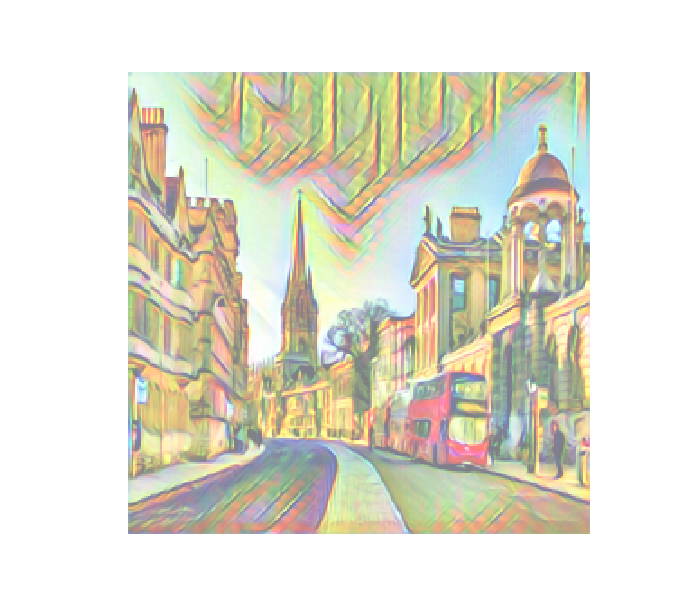

In [93]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW10')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 15
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW15', device, styleimage, \
                  content_weight=1, style_weight=15, var_weight=5)

<IPython.core.display.Javascript object>


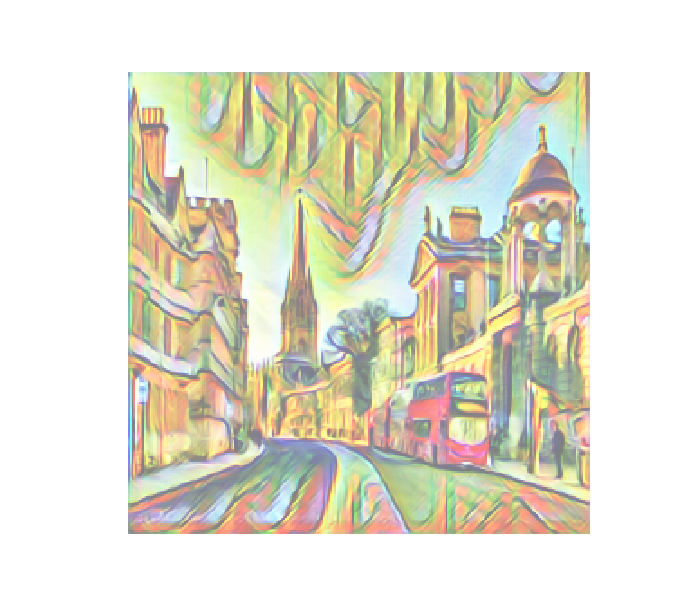

In [94]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW15')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 20
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW20', device, styleimage, \
                  content_weight=1, style_weight=20, var_weight=5)


<IPython.core.display.Javascript object>


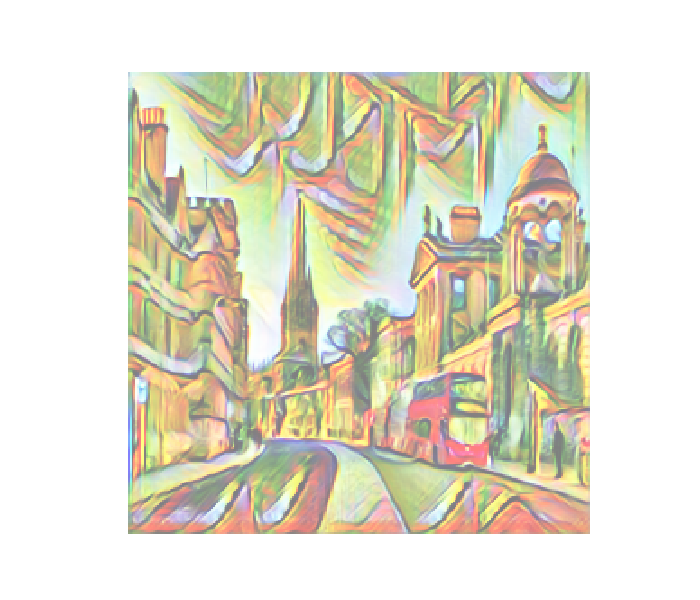

In [96]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW20')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 25
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW25', device, styleimage, \
                  content_weight=1, style_weight=25, var_weight=5)

<IPython.core.display.Javascript object>


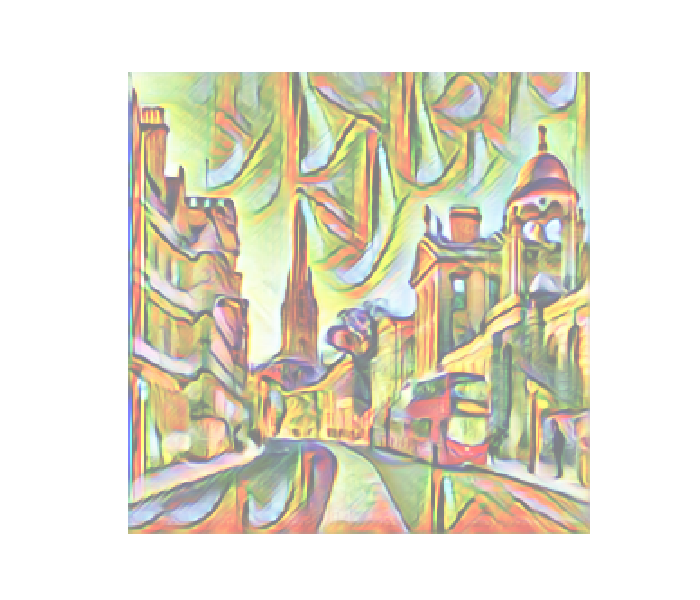

In [98]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW25')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 30
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW30', device, styleimage, \
                  content_weight=1, style_weight=30, var_weight=5)

<IPython.core.display.Javascript object>


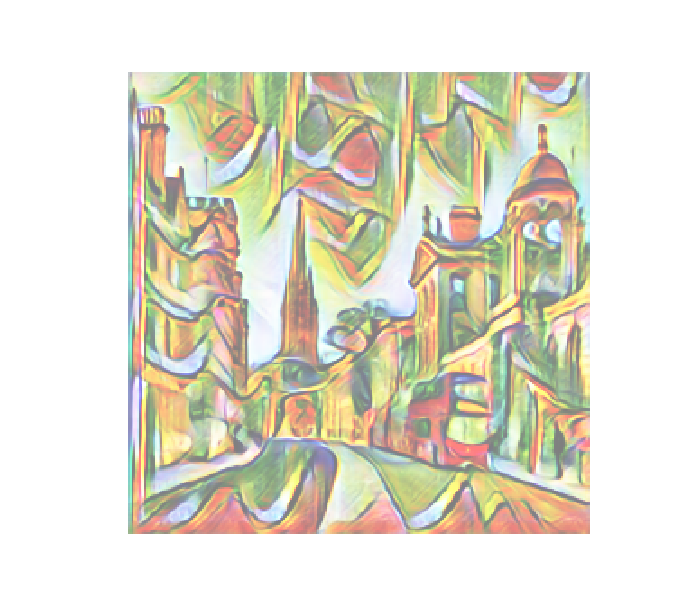

In [32]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW30')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a ImageTransform model as described by Johnson with style_weight = 35
JohnsonTransform = ImageTransform().to(device)

net, loss_history = styletransfer(train_set, JohnsonTransform, 'JohnsonModelSW35', device, styleimage, \
                  content_weight=1, style_weight=35, var_weight=5)

<IPython.core.display.Javascript object>


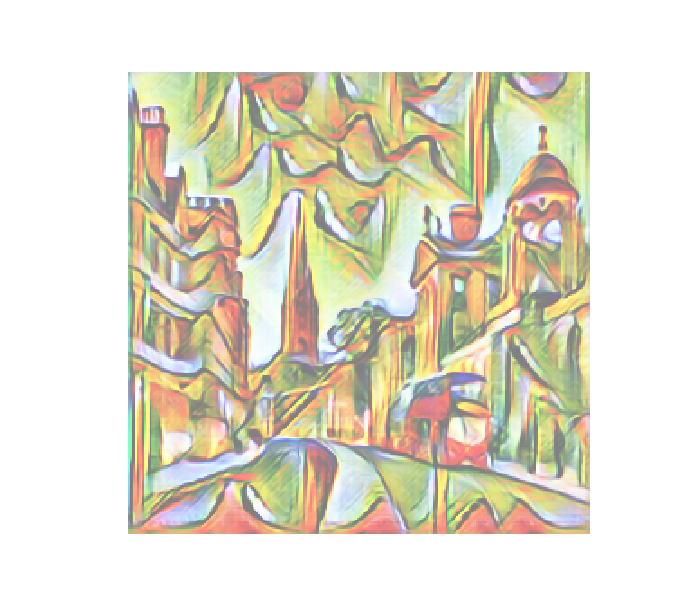

In [20]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW35')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DnCNN network with depth D = 4
DnCNN_net = DnCNN(4).to(device)

net, loss_history = styletransfer(train_set, DnCNN_net, 'DnCNNModelD4', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)


<IPython.core.display.Javascript object>


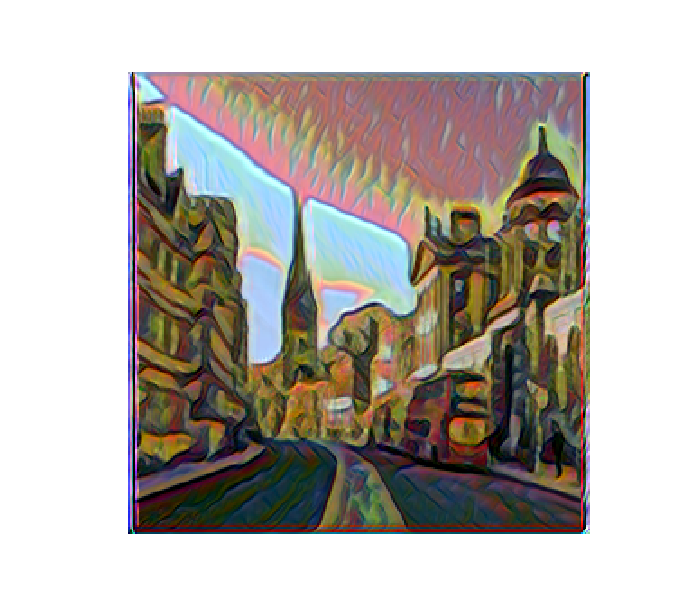

In [100]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DnCNNModelD4')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DnCNN network with depth D = 8
DnCNN_net = DnCNN(8).to(device)

net, loss_history = styletransfer(train_set, DnCNN_net, 'DnCNNModelD8', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)


<IPython.core.display.Javascript object>


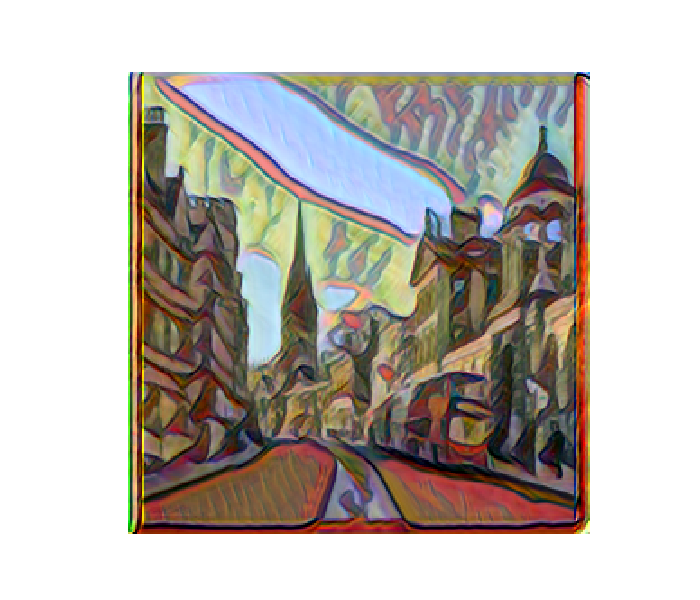

In [102]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DnCNNModelD8')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DnCNN network with depth D = 12
DnCNN_net = DnCNN(12).to(device)

net, loss_history = styletransfer(train_set, DnCNN_net, 'DnCNNModelD12', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)


<IPython.core.display.Javascript object>


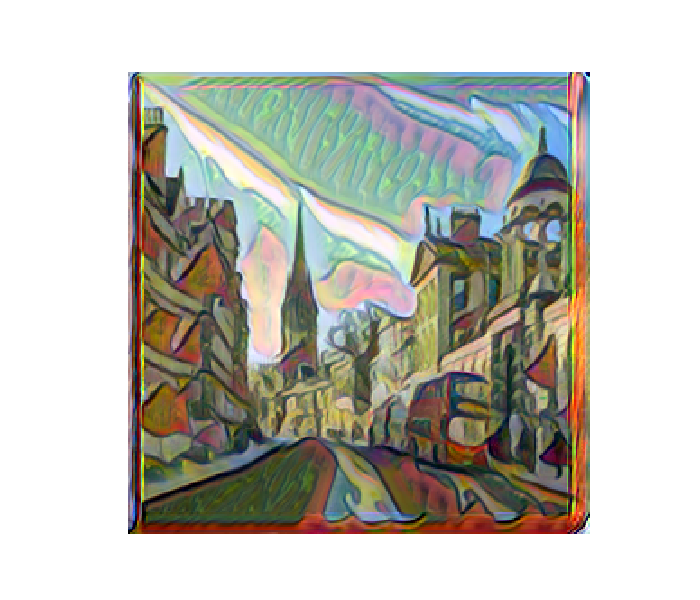

In [104]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DnCNNModelD12')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a UDnCNN network with depth D = 4
UDnCNN_net = UDnCNN(4).to(device)

net, loss_history = styletransfer(train_set, UDnCNN_net, 'UDnCNNModelD4', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


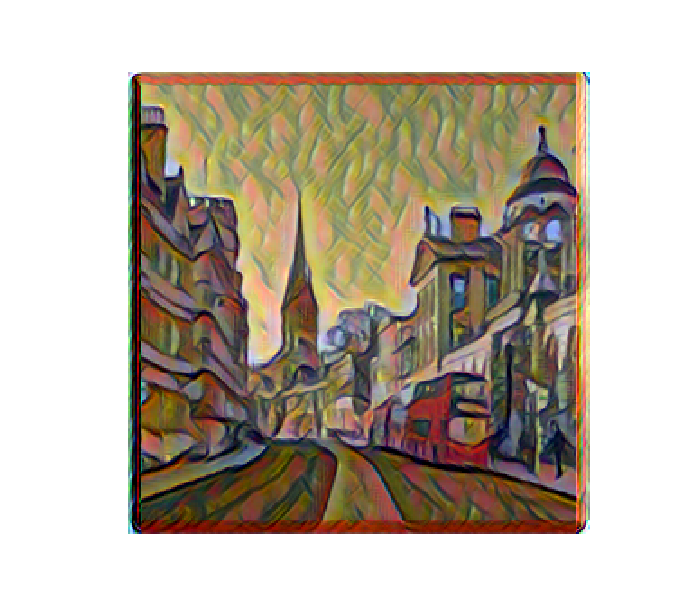

In [19]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('UDnCNNModelD4')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a UDnCNN network with depth D = 8
UDnCNN_net = UDnCNN(8).to(device)

net, loss_history = styletransfer(train_set, UDnCNN_net, 'UDnCNNModelD8', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


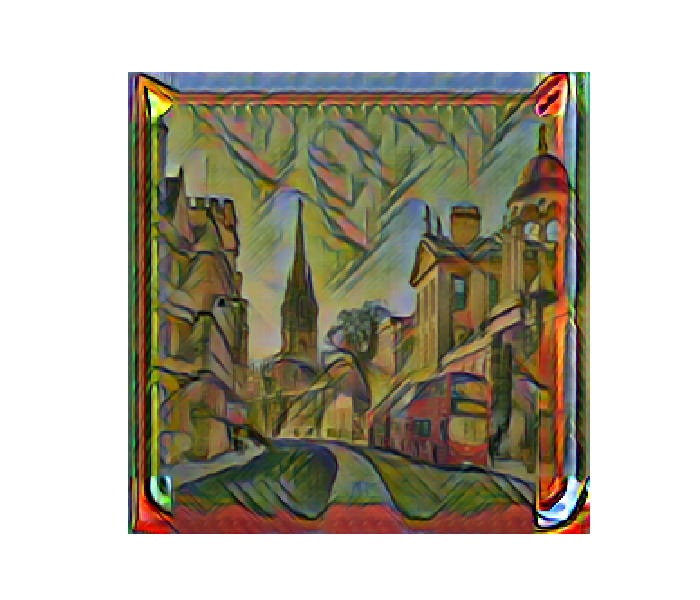

In [22]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('UDnCNNModelD8')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a UDnCNN network with depth D = 12
UDnCNN_net = UDnCNN(12).to(device)

net, loss_history = styletransfer(train_set, UDnCNN_net, 'UDnCNNModelD12', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


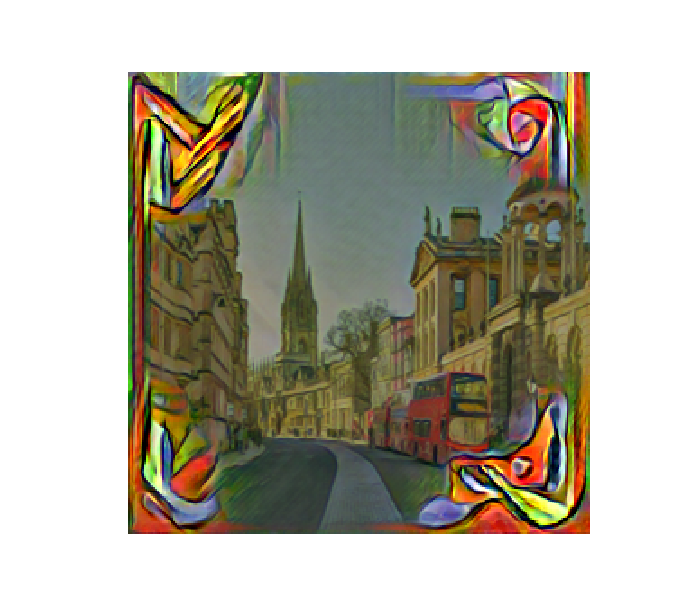

In [24]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('UDnCNNModelD12')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DUDnCNN network with depth D = 4
DUDnCNN_net = DUDnCNN(4).to(device)

net, loss_history = styletransfer(train_set, DUDnCNN_net, 'DUDnCNNModelD4', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


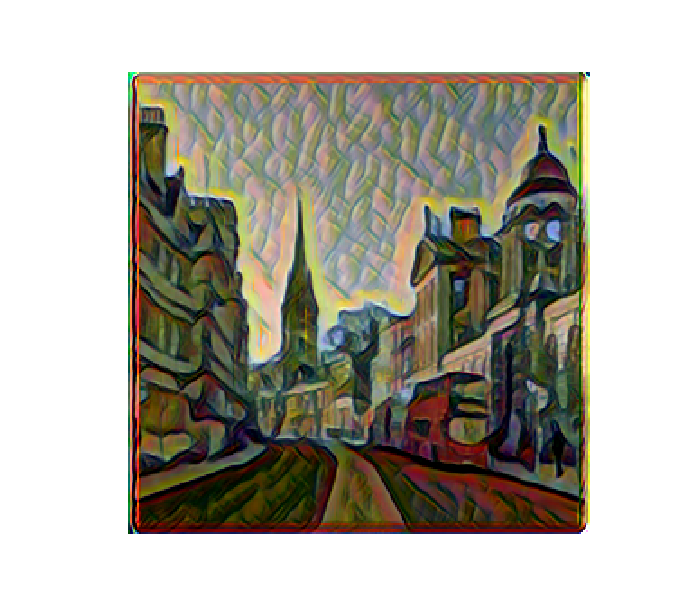

In [26]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DUDnCNNModelD4')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DUDnCNN network with depth D = 8
DUDnCNN_net = DUDnCNN(8).to(device)

net, loss_history = styletransfer(train_set, DUDnCNN_net, 'DUDnCNNModelD8', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


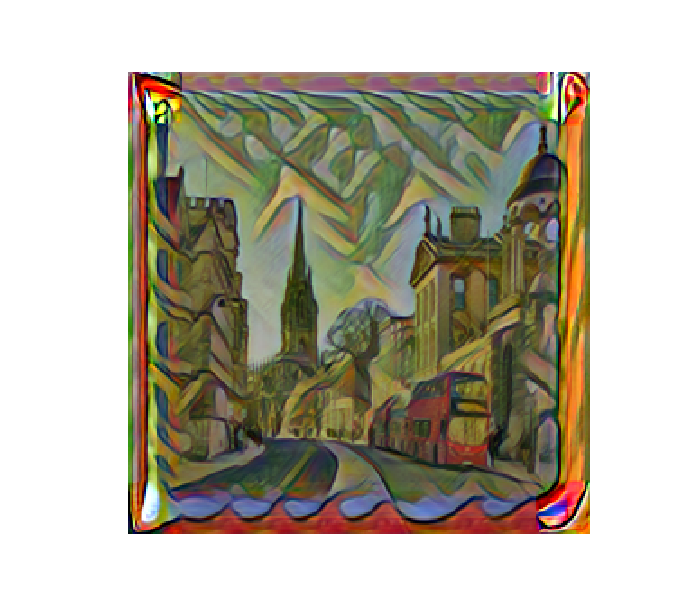

In [28]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DUDnCNNModelD8')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)

In [ ]:
# Train a DUDnCNN network with depth D = 12
DUDnCNN_net = DUDnCNN(12).to(device)

net, loss_history = styletransfer(train_set, DUDnCNN_net, 'DUDnCNNModelD12', device, styleimage, \
                  content_weight=1, style_weight=60, var_weight=5)

<IPython.core.display.Javascript object>


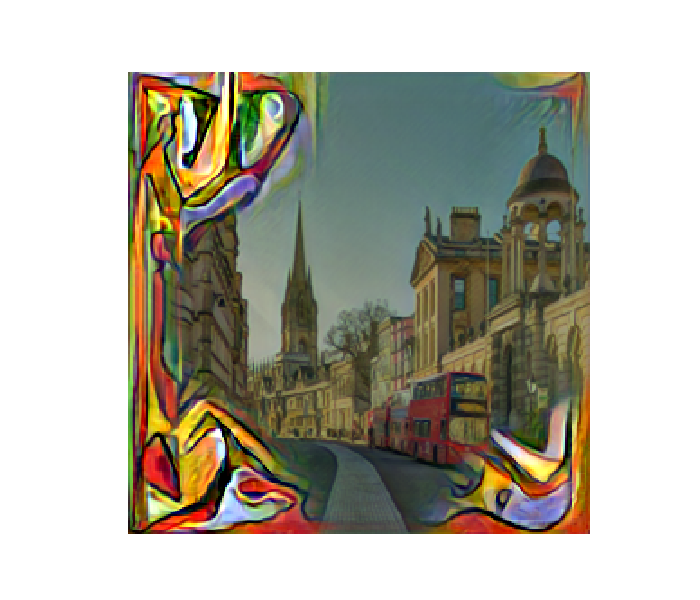

In [30]:
fig1, axes1 = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

model = torch.load('DUDnCNNModelD12')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
myimshow(stylized_image, axes1)